**21127671 - Nguyễn Hoàng Phúc**

## **Steam Games Analysis Project**


### Import neccessary libraries

In [860]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import asyncio
import json
from typing import List, Dict
import requests
import aiohttp  # Async HTTP requests
import nest_asyncio # Nested async loops in Jupyter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

## 1. Data Collection

### 1.1 SteamSpy API Data collection and processing

Since the official steam API returns all applications, not just games, and don't filter for spam apps, we will use SteamSpy as an alternative to get a quality list of games and information not found on the official API.


In [861]:
nest_asyncio.apply()

async def fetch_steamspy_page(session, page):
    # Fetch data from a single SteamSpy page
    base_url = 'https://steamspy.com/api.php'
    params = {'request': 'all', 'page': page}
    try:
        async with session.get(base_url, params=params) as response:
            if response.status == 200:
                return list((await response.json()).values())
            else:
                print(f"SteamSpy API error on page {page}: HTTP {response.status}")
                return []
    except Exception as e:
        print(f"SteamSpy API exception on page {page}: {e}")
        return []

async def fetch_all_steamspy_data(max_pages):
    # Fetch data from multiple SteamSpy pages asynchronously for better runtime
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_steamspy_page(session, page) for page in range(max_pages)]
        start_time = time.time()
        results = await asyncio.gather(*tasks)
        end_time = time.time()
        all_games = [game for page_games in results for game in page_games]
        print(f"Fetched {len(all_games)} games from SteamSpy in {end_time - start_time:.2f} seconds")
        return pd.DataFrame(all_games)

def get_steamspy_data(max_pages):
    # Manage asyncio event loop and call the fetch all function
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop.run_until_complete(fetch_all_steamspy_data(max_pages))

# max_pages_steamspy = 10 # 1000 games per page
# steamspy_df = get_steamspy_data(max_pages_steamspy)
# steamspy_df.to_csv('steamspy_data.csv', index=False)
# print("Saved steamspy_data.csv")

### 1.2 Steam API Data Collection and Processing

Since most Vietnamese ISPs blocked Steam DNS, a VPN is required to scrape data from Steam.

In [862]:
def fetch_steam_store_app_details(app_id):
    # Fetch app details from Steam Store API
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()[str(app_id)]
        if data.get('success') and 'data' in data:
            return data['data']
        else:
            print(f"No data found for app ID {app_id} in Steam Store. Details: {data}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Steam Store API error for app ID {app_id}: {e}")
        return None

def fetch_all_steam_store_data(app_ids):
    # Fetch data for multiple apps from Steam Store API
    steamstore_data = []
    total_apps = len(app_ids)
    for i, app_id in enumerate(app_ids):
        data = get_steam_store_app_details(app_id)
        if data:
            steamstore_data.append({
                'appid': data.get('steam_appid'),
                'name': data.get('name'),
                'languages': data.get('supported_languages'),
                'metacritic': data.get('metacritic'),
                'genres': data.get('genres')
            })
        if (i + 1) % 100 == 0 or (i + 1) == total_apps:
            print(f"\rProcessed {i + 1}/{total_apps} games from Steam Store", end="", flush=True)
        time.sleep(1.5)  # API rate limits
    print() 
    return pd.DataFrame(steamstore_data)

#app_ids = steamspy_df['appid'].tolist()

# Because of Steam rate limits, 10000 games take 4 hours to fetch so function call is commented out

# steamstore_df = get_all_steam_store_data(app_ids)
# steamstore_df.to_csv("steamstore_data.csv", index=False)
# print("Saved steamstore_data.csv")

## 2. Data Preprocessing


In [863]:
steamspy_df = pd.read_csv('steamspy_data.csv')
steamstore_df = pd.read_csv('steamstore_data.csv')
# floating point 2
steamspy_df.userscore = steamspy_df.positive / (steamspy_df.positive + steamspy_df.negative)
steamspy_df.drop(columns=['positive', 'negative'], inplace=True)
steamspy_df.head()

,appid,name,developer,publisher,score_rank,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
0,570,Dota 2,Valve,Valve,NaN,0.815787,"200,000,000 .. 500,000,000",40585,1304,910,812,0,0,0,643177
1,730,Counter-Strike: Global Offensive,Valve,Valve,NaN,0.869418,"100,000,000 .. 200,000,000",32232,732,5620,313,0,0,0,969773
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",NaN,0.588833,"50,000,000 .. 100,000,000",22327,847,5729,288,0,0,0,322362
3,1172470,Apex Legends,Respawn,Electronic Arts,NaN,0.676906,"50,000,000 .. 100,000,000",9613,464,726,144,0,0,0,78658
4,440,Team Fortress 2,Valve,Valve,NaN,0.885364,"50,000,000 .. 100,000,000",11888,1401,354,306,0,0,0,41811


In [864]:
steamstore_df.head()

,appid,name,languages,metacritic,genres
0,570,Dota 2,"Bulgarian, Czech, Danish, Dutch, English<stron...","{'score': 90, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."
1,730,Counter-Strike 2,"Czech, Danish, Dutch, English<strong>*</strong...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ..."
2,578080,PUBG: BATTLEGROUNDS,"English, Korean, Simplified Chinese, French, G...",NaN,"[{'id': '1', 'description': 'Action'}, {'id': ..."
3,1172470,Apex Legends™,"English<strong>*</strong>, French<strong>*</st...","{'score': 88, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."
4,440,Team Fortress 2,"English<strong>*</strong>, Danish, Dutch, Finn...","{'score': 92, 'url': 'https://www.metacritic.c...","[{'id': '1', 'description': 'Action'}, {'id': ..."


In [865]:
merged_df = pd.merge(steamspy_df, steamstore_df, on=['appid', 'name'], how='inner')
print(f"Number of games in merged_df: {merged_df.shape[0]}")
print(merged_df.isnull().sum())
merged_df = merged_df.dropna(subset=['languages','metacritic','genres'])
print(f"Number of games in merged_df after dropping : {merged_df.shape[0]}")

Number of games in merged_df: 9373
appid                 0
name                  0
developer            31
publisher            14
score_rank         9371
userscore             4
owners                0
average_forever       0
average_2weeks        0
median_forever        0
median_2weeks         0
price                 0
initialprice          0
discount              0
ccu                   0
languages             2
metacritic         6894
genres               26
dtype: int64
Number of games in merged_df after dropping : 2478


In [866]:
# Function to extract the Metacritic score from json string
def extract_metacritic_score(metacritic):
    if pd.isnull(metacritic):
        return None
    try:
        if isinstance(metacritic, str):
            metacritic = eval(metacritic)
        return metacritic.get('score')
    except:
        return None

# Function to count the number of languages
def count_languages(languages_str):
    if pd.isnull(languages_str) or not isinstance(languages_str, str):
        return 0
    languages_str = re.sub('<[^<]+?>', '', languages_str)
    return len(languages_str.split(','))

# Extract genres into a list
def extract_genres(genre_list):
    if pd.isnull(genre_list):
        return []
    try:
        # Convert string representation to list if necessary
        if isinstance(genre_list, str):
            genre_list = eval(genre_list)
        return [genre['description'].lower() for genre in genre_list]
    except:
        return []
    
# Apply the functions
merged_df['metacritic'] = merged_df['metacritic'].apply(extract_metacritic_score)
merged_df['languages'] = merged_df['languages'].apply(count_languages)

merged_df['genre_list'] = merged_df['genres'].apply(extract_genres)
# List of top genres to create boolean columns for
top_genres = ['indie', 'action', 'casual', 'adventure', 'simulation',
              'rpg', 'strategy', 'sports', 'racing', 'massively multiplayer']
# Create boolean columns for each top genre
for genre in top_genres:
    merged_df[f'genre_{genre}'] = merged_df['genre_list'].apply(lambda x: int(genre in x))
    
selected_columns = ['appid', 'name', 'metacritic', 'userscore', 'median_forever', 'ccu', 'price', 'languages']
selected_columns += [f'genre_{genre}' for genre in top_genres]
# Create the final DataFrame
processed_df = merged_df[selected_columns]
processed_df.rename(columns={'median_forever': 'median_playtime'}, inplace=True)

# Calculate median and replace zeros for playtime
median_of_median_playtime = int(processed_df[processed_df['median_playtime'] > 0]['median_playtime'].median())
processed_df.loc[processed_df['median_playtime'] == 0, 'median_playtime'] = median_of_median_playtime

# Apply log transformation to playtime
processed_df = processed_df.copy()
processed_df['median_playtime'] = processed_df['median_playtime'].astype('float64')
processed_df['median_playtime'] = np.log1p(processed_df['median_playtime'])

# calculate median and replace zeros for concurrent users
median_of_ccu = int(processed_df[processed_df['ccu'] > 0]['ccu'].median())
processed_df.loc[processed_df['ccu'] == 0, 'ccu'] = median_of_ccu
# Apply log transformation to concurrent users
processed_df = processed_df.copy()
processed_df['ccu'] = processed_df['ccu'].astype('float64')
processed_df['ccu'] = np.log1p(processed_df['ccu'])


C:\Users\PHUC\AppData\Local\Temp\ipykernel_27472\2275166627.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.rename(columns={'median_forever': 'median_playtime'}, inplace=True)


## 3. Exploratory Data Analysis

In [867]:
processed_df.head()

,appid,name,metacritic,userscore,median_playtime,ccu,price,languages,genre_indie,genre_action,genre_casual,genre_adventure,genre_simulation,genre_rpg,genre_strategy,genre_sports,genre_racing,genre_massively multiplayer
0,570,Dota 2,90,0.815787,6.814543,13.374177,0,28,0,1,0,0,0,0,1,0,0,0
2,440,Team Fortress 2,92,0.885364,5.872118,10.640939,0,27,0,1,0,0,0,0,0,0,0,0
6,271590,Grand Theft Auto V,96,0.870286,8.812843,11.667285,2430,13,0,1,0,1,0,0,0,0,0,0
7,550,Left 4 Dead 2,89,0.975087,6.274762,10.236131,200,28,0,1,0,0,0,0,0,0,0,0
8,252490,Rust,69,0.871065,7.893572,11.794036,3999,25,1,1,0,1,0,1,0,0,0,1


In [868]:
print(f"Number of games in processed_df: {processed_df.shape[0]}")


Number of games in processed_df: 2478


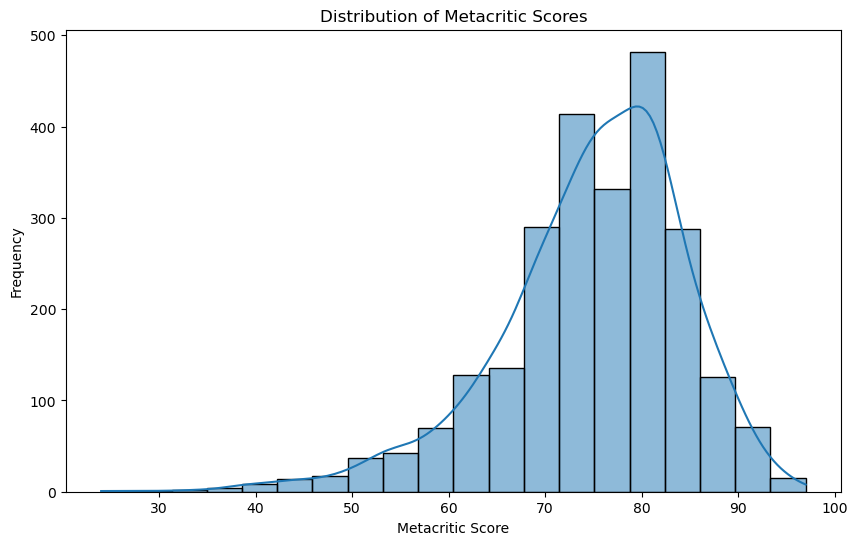

In [869]:
# Histogram of Metacritic scores
plt.figure(figsize=(10, 6))
sns.histplot(processed_df['metacritic'], bins=20, kde=True)
plt.title('Distribution of Metacritic Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('Frequency')
plt.show()

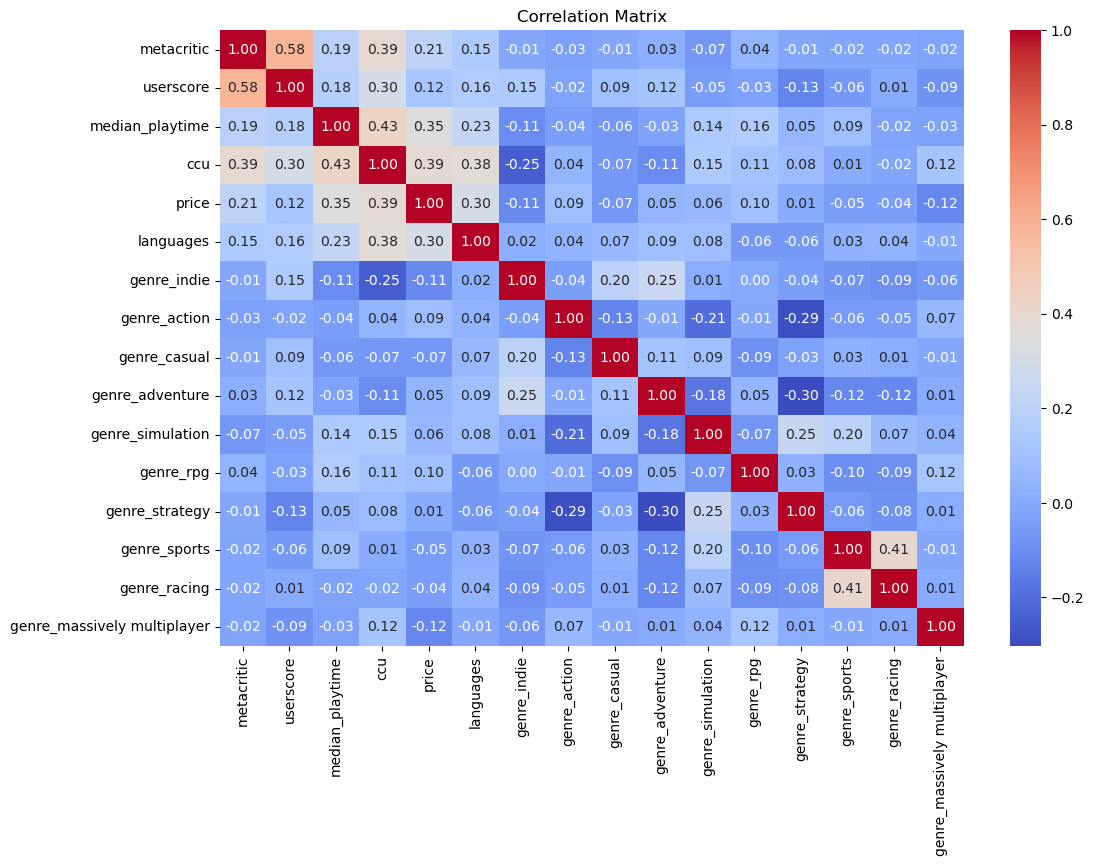

In [870]:
# Compute correlation matrix
corr_matrix = processed_df.drop(columns=['appid', 'name']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

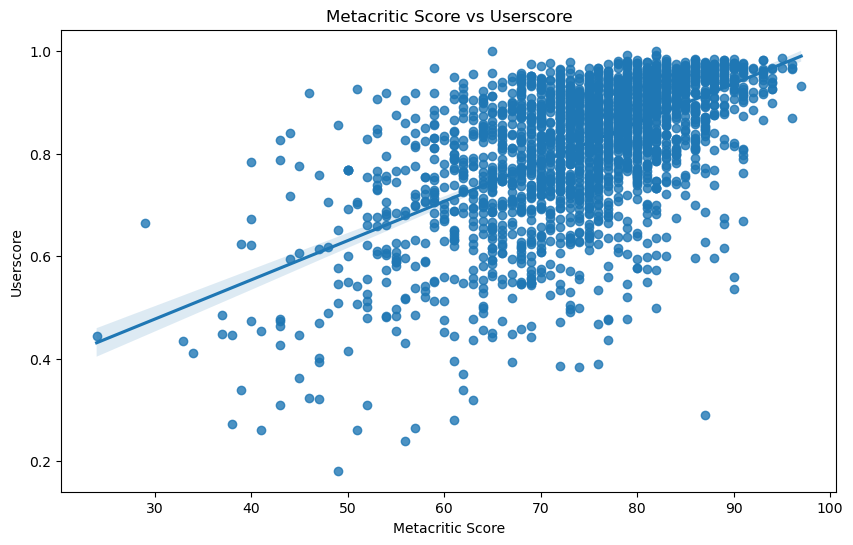

In [871]:
# Metacritic Score vs Userscore
plt.figure(figsize=(10, 6))
sns.regplot(x='metacritic', y='userscore', data=processed_df)
plt.title('Metacritic Score vs Userscore')
plt.xlabel('Metacritic Score')
plt.ylabel('Userscore')
plt.show()

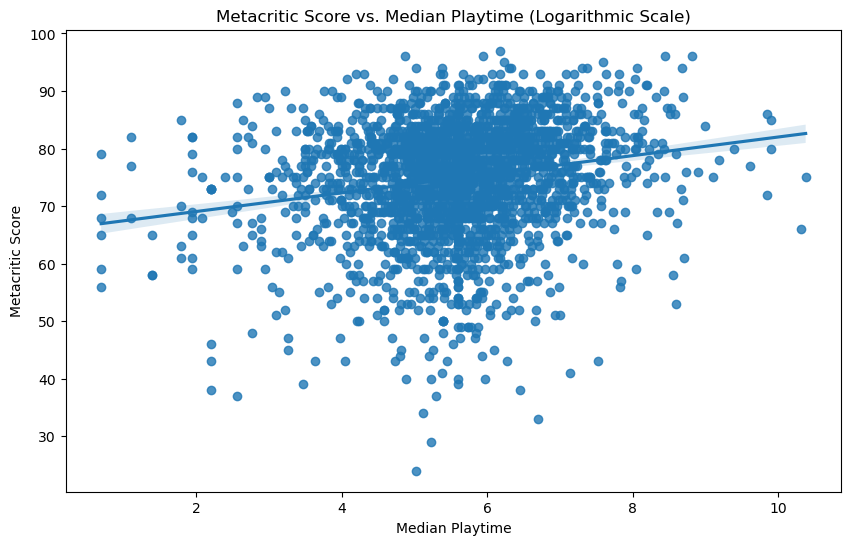

In [872]:
plt.figure(figsize=(10, 6))
sns.regplot(x=processed_df['median_playtime'], y='metacritic', data=processed_df)  # Log transformation
plt.xlabel('Median Playtime')
plt.ylabel('Metacritic Score')
plt.title('Metacritic Score vs. Median Playtime (Logarithmic Scale)')
plt.show()

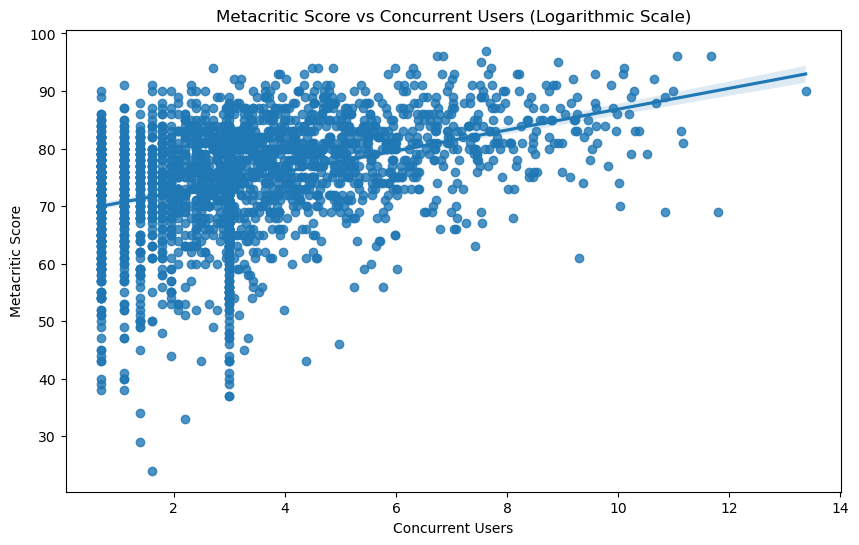

In [873]:
# Metacritic score vs concurrent users
plt.figure(figsize=(10, 6))
sns.regplot(x='ccu', y='metacritic', data=processed_df)
plt.title('Metacritic Score vs Concurrent Users (Logarithmic Scale)')
plt.xlabel('Concurrent Users')
plt.ylabel('Metacritic Score')
plt.show()

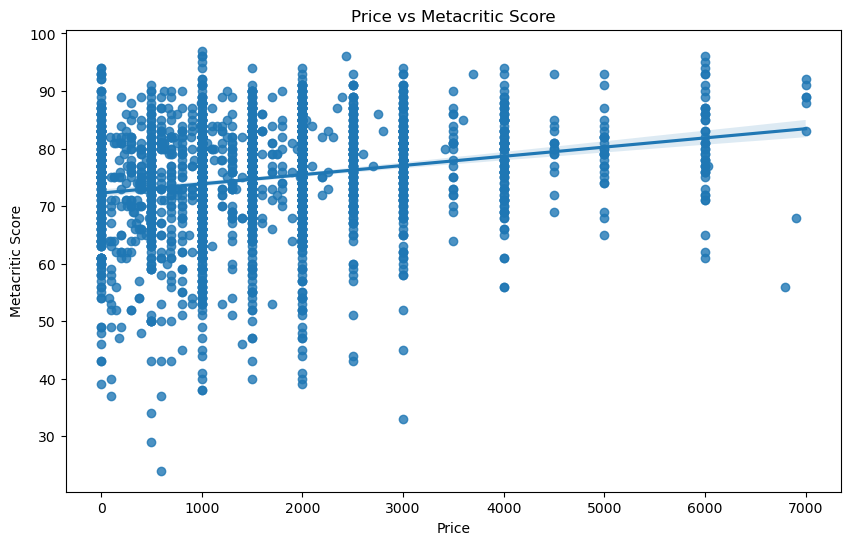

In [874]:
# Scatter plot of Price vs Metacritic Score
plt.figure(figsize=(10, 6))
sns.regplot(x='price', y='metacritic', data=processed_df)
plt.title('Price vs Metacritic Score')
plt.xlabel('Price')
plt.ylabel('Metacritic Score')
plt.show()


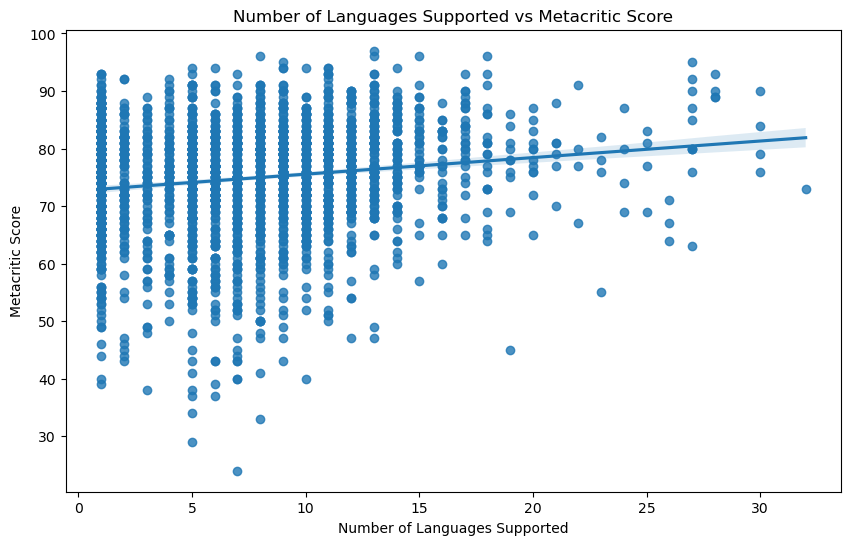

In [ ]:
# Number of Languages vs Metacritic Score
plt.figure(figsize=(10, 6))
sns.regplot(x='languages', y='metacritic', data=processed_df)
plt.title('Number of Languages Supported vs Metacritic Score')
plt.xlabel('Number of Languages Supported')
plt.ylabel('Metacritic Score')
plt.show()


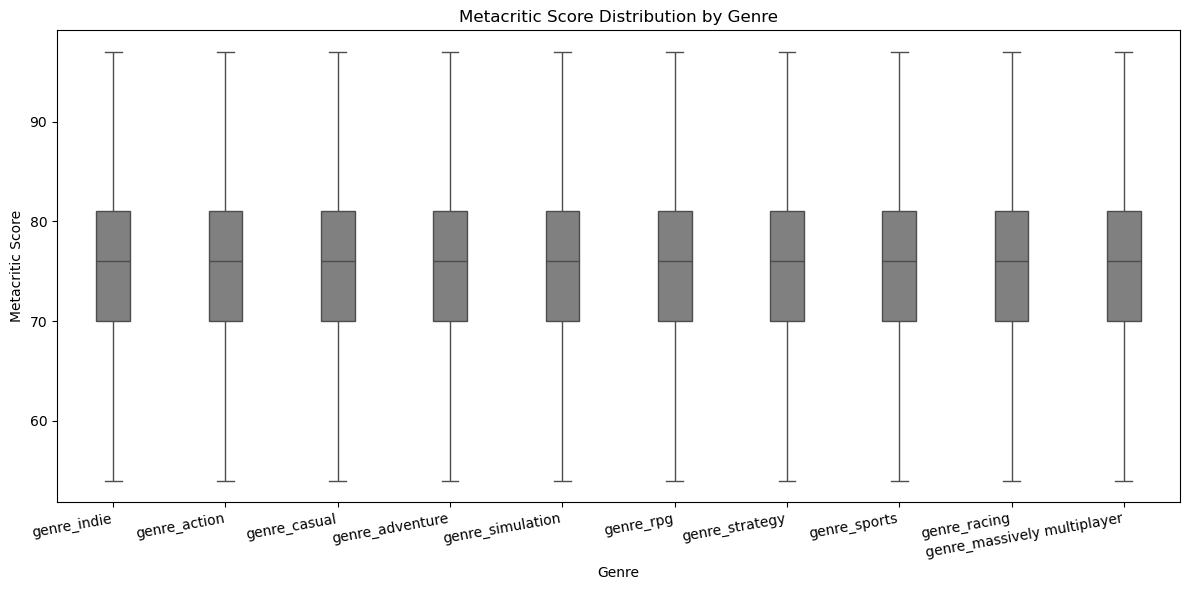

In [876]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='metacritic', data=processed_df.melt(id_vars=['metacritic'], 
                                                               value_vars=[f'genre_{genre}' for genre in top_genres],
                                                               var_name='genre', value_name='present'),
            color='gray', showfliers=False, width=0.3) 
plt.xticks(rotation=10, ha='right')
plt.xlabel('Genre')
plt.ylabel('Metacritic Score')
plt.title('Metacritic Score Distribution by Genre')
plt.tight_layout()
plt.show()


### Analysis of the data
- Metacritic scores and userscores are the only highly correlated features.
- Metacritic scores do not diverge much between each genres.

## 4. Data Modeling

In [877]:
y = processed_df['metacritic']
X = processed_df.drop(columns=['appid', 'name', 'metacritic'])

# Handle any missing values in X or y
X = X.dropna()
y = y.loc[X.index]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [878]:
scaler = StandardScaler()
numerical_cols = ['userscore', 'median_playtime', 'ccu', 'price', 'languages']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [879]:
# Linear Regression Model

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Training MSE: {mse_train:.2f}, R2: {r2_train:.2f}")
print(f"Testing MSE: {mse_test:.2f}, R2: {r2_test:.2f}")


Training MSE: 56.65, R2: 0.42
Testing MSE: 53.72, R2: 0.34


In [880]:
# Decision Tree Regressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# Evaluate the model
mse_train_dt = mean_squared_error(y_train, y_pred_train_dt)
mse_test_dt = mean_squared_error(y_test, y_pred_test_dt)
r2_train_dt = r2_score(y_train, y_pred_train_dt)
r2_test_dt = r2_score(y_test, y_pred_test_dt)

print(f"Decision Tree - Training MSE: {mse_train_dt:.2f}, R2: {r2_train_dt:.2f}")
print(f"Decision Tree - Testing MSE: {mse_test_dt:.2f}, R2: {r2_test_dt:.2f}")


Decision Tree - Training MSE: 0.00, R2: 1.00
Decision Tree - Testing MSE: 110.62, R2: -0.35


In [886]:
# Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate the model
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - Training MSE: {mse_train_rf:.2f}, R2: {r2_train_rf:.2f}")
print(f"Random Forest - Testing MSE: {mse_test_rf:.2f}, R2: {r2_test_rf:.2f}")

Random Forest - Training MSE: 8.04, R2: 0.92
Random Forest - Testing MSE: 51.27, R2: 0.37


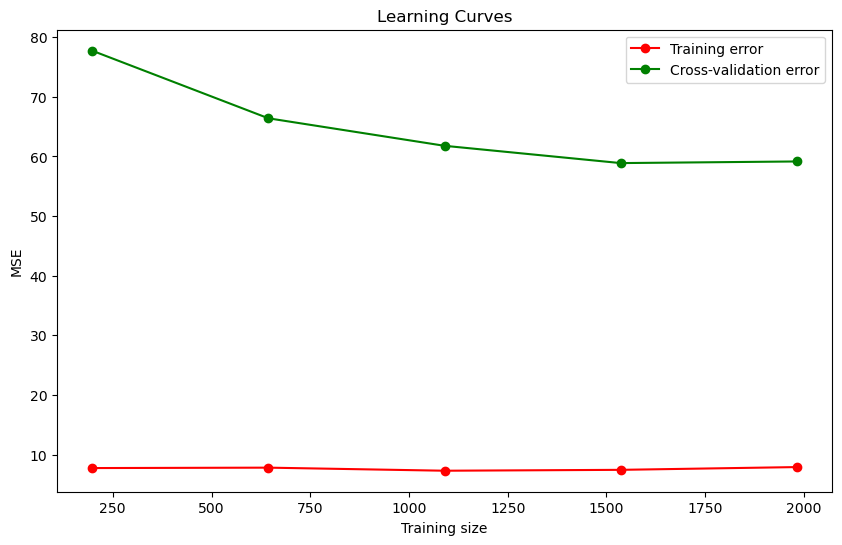

In [882]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(random_state=42),
    X,
    y,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()


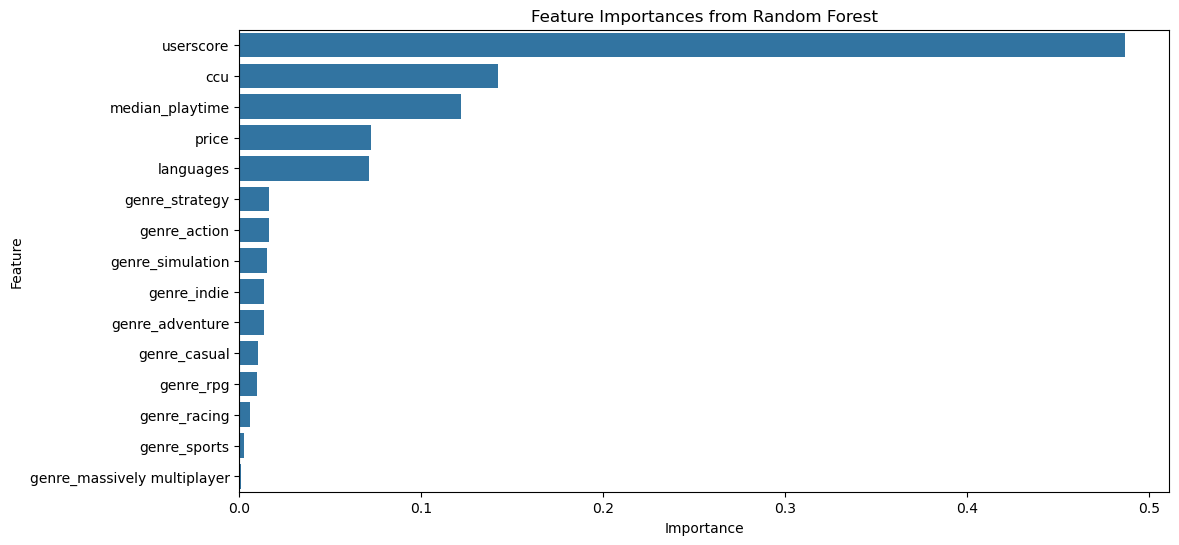

In [883]:
# Feature importance from Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()


### Modeling results
Linear Regression have low R2 on both train and test set -> Underfitting.

Decision Tree Regressor is perfectly fitting the training data, but perform very poorly on test set -> Overfitting. This suggests there are still noise in the data.

Random Forest Regressor fits the training data reasonably well, but also do not generalize well to the testing data.

### Conclusion:

Even though the learning curve of Random Forest is plateauing, we can still improve the model by adding more data and tuning the hyperparameters.


Plan: Add feature "Age", double the dataset. Figure out how to remove noise.